In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mypath=[]
for name in glob("drive/My Drive/dataset/9043/*",recursive=True):
    mypath.append(name)
    print(name)    

drive/My Drive/dataset/9043/0
drive/My Drive/dataset/9043/1


In [ ]:
len(mypath)

2

In [ ]:
import os
mypath=[]
for dirname, _, filenames in os.walk("./drive/ My Drive/dataset/9043"):
    for filename in filenames:
        mypath.append(os.path.join(dirname, filename))
class0=[]
class1=[]
for i in mypath:
    if '1.png' in i:
        class1.append(i)
    else:
        class0.append(i)         

In [ ]:
mypath[0:5]

['./drive/ My Drive/dataset/9043/0/9041_idx5_x2251_y1251_class1.png',
 './drive/ My Drive/dataset/9043/0/9041_idx5_x2251_y1301_class1.png',
 './drive/ My Drive/dataset/9043/0/9041_idx5_x2251_y1351_class1.png',
 './drive/ My Drive/dataset/9043/0/9041_idx5_x2251_y1401_class1.png',
 './drive/ My Drive/dataset/9043/0/9041_idx5_x2251_y1451_class1.png']

In [ ]:
class0[0:5]


['./drive/ My Drive/dataset/9043/0/9043_idx5_x101_y1001_class0.png',
 './drive/ My Drive/dataset/9043/0/9043_idx5_x101_y1051_class0.png',
 './drive/ My Drive/dataset/9043/0/9043_idx5_x101_y1101_class0.png',
 './drive/ My Drive/dataset/9043/0/9043_idx5_x101_y701_class0.png',
 './drive/ My Drive/dataset/9043/0/9043_idx5_x101_y751_class0.png']

In [ ]:
print(len(class0),len(class1))

296 605


In [ ]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
sampled_class0 = random.sample(class0,len(class0))
sampled_class1 = random.sample(class1, len(class1))
len(sampled_class0)
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
      if i.endswith('.png'):
        img = cv2.imread(i ,cv2.IMREAD_COLOR)
        img_sized = np.array(cv2.resize(img, (224, 224)))
        img_arrays.append([img_sized, label])
    return img_arrays

class0=None;
class1=None;
import gc
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

print('done')

done


In [ ]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
len(combined_data)

901

In [ ]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [ ]:
print(len(X))
print(len(y))


901
901


In [ ]:
X = np.array(X).reshape(-1, 224, 224, 3)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

num_classes = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test, num_classes)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(810, 224, 224, 3) (91, 224, 224, 3) (810, 10) (91, 10)


In [ ]:
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

In [ ]:
X_train=X_train/255.0
X_test=X_test/255.0

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)


In [ ]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')
x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [ ]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [ ]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(learning_rate=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=256, callbacks=[lr_sc])

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
4/4 [==============================] - 74s 3s/step - loss: 3.1720 - output_loss: 1.9972 - auxilliary_output_1_loss: 1.8653 - auxilliary_output_2_loss: 2.0504 - output_accuracy: 0.3494 - auxilliary_output_1_accuracy: 0.3579 - auxilliary_output_2_accuracy: 0.2982 - val_loss: 1.0483 - val_output_loss: 0.6465 - val_auxilliary_output_1_loss: 0.6660 - val_auxilliary_output_2_loss: 0.6731 - val_output_accuracy: 0.7253 - val_auxilliary_output_1_accuracy: 0.7253 - val_auxilliary_output_2_accuracy: 0.7253
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
4/4 [==============================] - 3s 608ms/step - loss: 1.2744 - output_loss: 0.8395 - auxilliary_output_1_loss: 0.7235 - auxilliary_output_2_loss: 0.7263 - output_accuracy: 0.7196 - auxilliary_output_1_accuracy: 0.6879 - auxilliary_output_2_accuracy: 0.6629 - val_loss: 1.1497 - val_output_loss: 0.7775 - val_auxilliary_output_1_loss: 

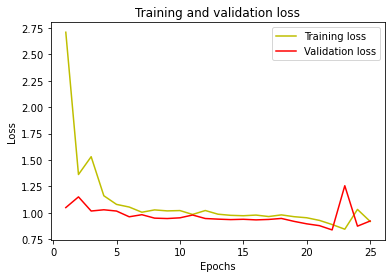

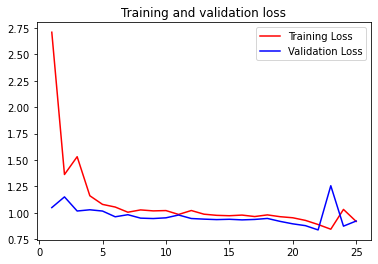

In [ ]:
#plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['output_accuracy']
val_acc = history.history['val_output_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
# epochs = range(len(acc))
  
# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
  
plt.figure()
  
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
e=model.evaluate(X_test,y_test)

3/3 [==============================] - 5s 642ms/step - loss: 0.9211 - output_loss: 0.5740 - auxilliary_output_1_loss: 0.5890 - auxilliary_output_2_loss: 0.5681 - output_accuracy: 0.7253 - auxilliary_output_1_accuracy: 0.7912 - auxilliary_output_2_accuracy: 0.8242


In [ ]:
y_pred=model.predict(X_test)

In [ ]:
len(y_pred[0])

91

In [ ]:
Y_pred=[]
for i in y_pred[0]:
    if (i[0]>i[1]).all():
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [ ]:
Y_test=[]
for i in y_test:
    if (i[0]>i[1]).all():
        Y_test.append(0)
    else:
        Y_test.append(1)

In [ ]:
Y_pred

In [ ]:
Y_test

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test, Y_pred))
print('Classification Report')
print(classification_report(Y_test, Y_pred, target_names=['Class-0','Class-1'], zero_division='warn'))

Confusion Matrix
[[66  0]
 [25  0]]
Classification Report
              precision    recall  f1-score   support

     Class-0       0.73      1.00      0.84        66
     Class-1       0.00      0.00      0.00        25

    accuracy                           0.73        91
   macro avg       0.36      0.50      0.42        91
weighted avg       0.53      0.73      0.61        91



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classes=[0,1]
con_mat_df = pd.DataFrame(confusion_matrix(Y_test, Y_pred),index = classes, columns = classes)

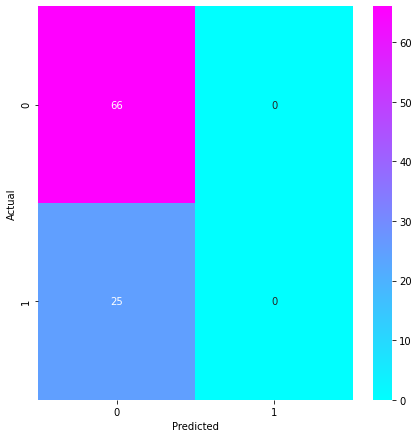

In [ ]:
con_mat_df
import seaborn as sns
figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()